%% Packages

In [21]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import inv,cholesky
from numpy import arange, exp, sqrt, log, mean, std, nonzero, isnan, array, zeros, ones, maximum, minimum
from numpy import concatenate, arange, interp, diff, cov, var, diag, eye, cumsum, tile, transpose, nan, hstack, vstack
from numpy import setdiff1d,polyfit,polyval,gradient,argmin,argmax,amax,amin,flipud,corrcoef
from scipy.interpolate import interp1d, PchipInterpolator
from scipy.optimize import fmin,fsolve
from scipy.stats import norm
from scipy.special import ndtri # inverse of norm.cdf
from numpy.random import normal,uniform
from mpl_toolkits.mplot3d import Axes3D
from BSfwd import BSfwd
from minfunBDTNew import minfunBDTNew,minfunBDTNew_fsolve

In [22]:
plt.close('all')   # Close all charts

% BDT Model

DATA

Text(0.5, 1.0, 'LIBOR Curve and Forward Curve')

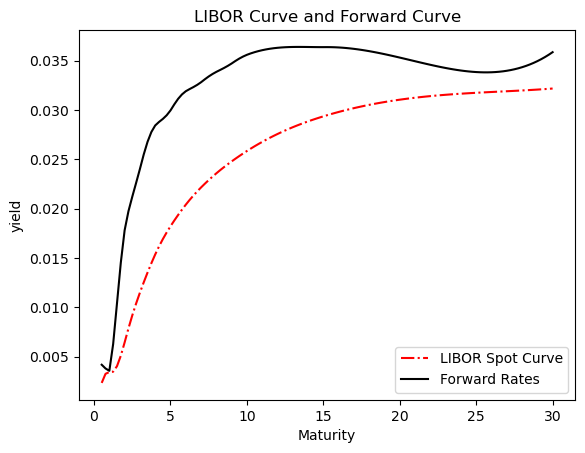

In [23]:
SwRates = array([0.152,0.2326,0.3247,0.346,0.7825,1.2435,1.599,1.853,2.052,2.2085,2.3371,2.4451,2.539,2.843,2.9863,3.0895])    # includes 1-, 3-, 6- month LIBOR as first 3 entries
CapsVol = array([68.53,63.63,54.06,48.43,44.87,42.03,43.35,38.03,36.54,38.45,33.13,29.97,26.91,24.95,23.65])
SwRates = SwRates/100  # transform in decimals
CapsVol = CapsVol/100  # transform in decimals
MaturitySwaps = array([1/12,3/12,6/12,1,2,3,4,5,6,7,8,9,10,15,20,30])    # maturities of Swaps
MaturityCaps  = array([1,2,3,4,5,6,7,8,9,10,12,15,20,25,30])             # maturities of Caps
dt = 0.25     # time step: Quarterly (as caps are quarterly).
CapsVol = hstack((CapsVol[0],CapsVol))
MaturityCaps = hstack((dt,MaturityCaps))
IntMat = arange(dt,30+dt,dt)
f      = interp1d(MaturitySwaps,SwRates,kind='cubic'); IntSwRate = f(IntMat)
f      = interp1d(MaturityCaps,CapsVol,kind='cubic');  IntVol    = f(IntMat)
ZSw      = zeros(IntSwRate.shape[0])
ZSw[0] = 1/(1+IntSwRate[0]*dt)
NN       = ZSw.shape[0]
for i in range(1,ZSw.shape[0]):
    ZSw[i] = (1-IntSwRate[i]*dt*np.sum(ZSw[0:i]))/(1+IntSwRate[i]*dt)
c2 = zeros(ZSw.shape[0])
for i in range(ZSw.shape[0]):
    c2[i] = (1-ZSw[i])/(np.sum(ZSw[0:i+1])*dt)
Zyieldcc = -log(ZSw)/IntMat
# Transform them into quarterly compounding
Zyield = 1/dt*(exp(Zyieldcc*dt)-1)
r0cc = -log(ZSw[0])/IntMat[0]
# in quarterly compounding
r0 = 1/dt*(exp(r0cc*dt)-1)
fwdcc = -log(ZSw[1:NN]/ZSw[0:NN-1])/dt
# compute quarterly compounded fwds
Fwd = 1/dt*(exp(fwdcc*dt)-1)
plt.figure(1)
plt.plot(IntMat[1:NN],Zyield[0:NN-1],'-.r',IntMat[1:NN],Fwd[0:NN-1],'-k')
plt.legend(('LIBOR Spot Curve','Forward Rates','location','southeast'))
plt.xlabel('Maturity')
plt.ylabel('yield')
plt.title('LIBOR Curve and Forward Curve')    

Augment Volatility data vector assuming *constant* volatility for short term caps

Augment maturity using 3 month

Interpolation using dt steps

% BOOSTRAP DISCOUNTS FROM INTERPOLATED SWAP RATES (TN 1)

double check: Does ZSw imply the original swap curve?

Compute continuously compounded yield

% Extract Forward Volatities

Initialize cap vector

In [24]:
Caps = zeros(NN-1)
for i in range(NN-1):
    Caps[i] = np.sum(dt*BSfwd(Fwd[0:i+1],IntSwRate[i+1],ZSw[1:i+2],IntVol[i+1],IntMat[0:i+1],1))

ImplVol      = zeros(NN-1)
Caplet       = zeros(NN-1)
CapletMatrix = zeros((NN-1,NN-1))

VVV = arange(0.00001,1.4+0.00001,0.00001)    # possible vectors of volatilities. It will be used below to compute the implied Fwd volatilities

ImplVol[0]      = IntVol[1]         # the first Fwd vol = Flat Vol
Caplet[0]       = Caps[0]         # the first caplet = cap with the first maturity
CapletMatrix[0,0] = Caplet[0]       # initialization of a caplet matrix

for i in range(1,NN-1):

    # compute caplets corresponding to maturities 1 to i-1 using the previously computed Fwd Volatilities (Vector ImplVol)
    CapletMatrix[0:i,i] = dt*BSfwd(Fwd[0:i],IntSwRate[i+1],ZSw[1:i+1],ImplVol[0:i],IntMat[0:i],1)

    # Compute the value of the sum of caplets up to maturity i-1
    SumCaplets = np.sum(dt*BSfwd(Fwd[0:i],IntSwRate[i+1],ZSw[1:i+1],ImplVol[0:i],IntMat[0:i],1))

    # The value of caplet with maturity i must equal the value of the cap with that maturity minus the previously compute sum of caplets
    Caplet[i] = Caps[i] - SumCaplets

    # Fill in the Caplet matrix for the missing i caplet
    CapletMatrix[i,i] = Caplet[i]

    # Obtained implied volatility. Idea is: compute the value of the caplet for each of the values in VVV vector,
    # and find the minimum of the distance between the Black's formula (on the grid VVV) and the Caplet value computed above.
    iV = argmin((dt*BSfwd(Fwd[i],IntSwRate[i+1],ZSw[i+1],VVV,IntMat[i],1)-Caplet[i])**2)

    # The implied volatility is just the value of VVV that minimizes the distance in the previous step, that is, element iV in the vector VVV;
    ImplVol[i] = VVV[iV]



Text(0.5, 1.0, 'Forward and Flat Volatility')

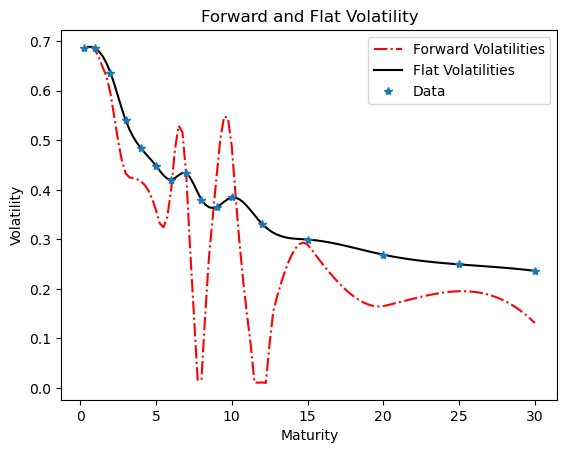

In [25]:
plt.figure(2)
plt.plot(IntMat[1:NN],ImplVol[0:NN-1],'-.r',IntMat[1:NN],IntVol[1:NN],'-k',MaturityCaps,CapsVol,'*')
plt.legend(('Forward Volatilities','Flat Volatilities','Data'))
plt.xlabel('Maturity')
plt.ylabel('Volatility')
plt.title('Forward and Flat Volatility')

FIRST, compute the dollar values of the caps for all maturities.<br>
      It uses BSfwd = Black's formula m-file

In [26]:
# Note:
    # IntMat:   maturity "T" into Black's model (to compute d1, d2)
    # Fwd:      Fwd Rates to be used in Blacks model
    # IntSwRate: Swap Rate. This is "shifted" one quarter ahead. The reason
    #           is that this is the strike rate of the (T+1 quarter) cap, which we
    #           are computing.
    # ZSw:      Discount Function. Also this is shifter one quarter ahead,
    #           as recall that something determined at T is paid at T+1
    #           quarter
    # IntVol:   Flat Volatility interpolated from the data.

% SECOND, compute caplets which use forward vols instead of Flat vols.

Start computing FWD Vols.

Loop for all the other maturities

%% BUILD THE BDT TREE for MBS

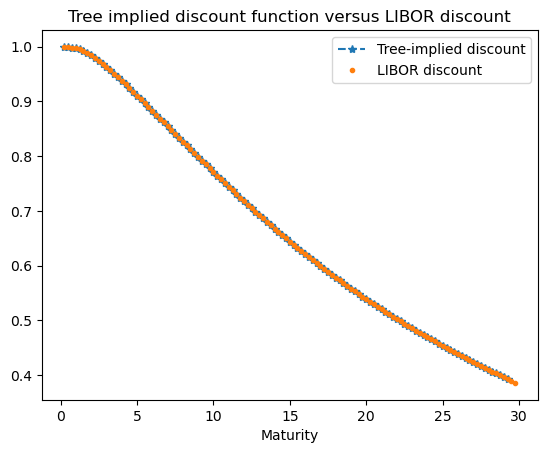

In [27]:
dtstep = 1/4  # monthly steps in BDT model (Note: by choosing dtstep = 1/4 we can check whether the BDT model prices zeros and caps correctly. See below)
if dtstep==1/4:
    IntMat2  = IntMat
    ImplVol2 = ImplVol
    ZSw2     = ZSw
elif dtstep<1/4:
    ImplVol2 = hstack((ImplVol[0],ImplVol))
    ZSw2     = hstack((1/(1+SwRates[0]*1/12),ZSw))


Maturity = arange(dtstep,amax(IntMat[0:-1])+dtstep,dtstep)
f        = interp1d(IntMat2,ZSw2); ZSwInt = f(Maturity)
ZYield   = -log(ZSwInt[0:-1])/Maturity[0:-1]
f        = interp1d(IntMat2[0:-1],ImplVol2); FwdVol = f(Maturity)

NN = ZYield.shape[0]  # size of zero-coupon yield vector

dy     = 0
ZYield = ZYield + dy
ImTree = zeros((NN,NN))
ImTree[0,0] = ZYield[0]
xx = ZYield[0] # starting value in the search engine

for j in range(NN-1):
    xx = xx*0.75 # starting value of search

    # use minfunBDTNew.m file to solve the for the interest rate such
    # that the zero coupon bond out of the tree equals the zero coupon bond from the data
    xx = fsolve(func=minfunBDTNew_fsolve,x0=xx,args=(ImTree,ZYield[j+1],FwdVol[j],Maturity[j+1]-Maturity[j],j+2))

    # plug back the solution in the mfile minfunBDTNew.m and obtain the vector of interest rate values
    F,vec = minfunBDTNew(xx,ImTree,ZYield[j+1],FwdVol[j],Maturity[j+1]-Maturity[j],j+2)

    # update the tree
    ImTree[0:j+2,j+1] = vec

ZTree = zeros((NN,NN,NN))
for i in arange(1,NN): # add one step to maturity to ensure the last bond has 30/dt to maturity (i=2 has 6 months to maturity)
    ZTree[0:i+1,i,i] = 1 # initialize tree with maturity i
    # backward algorithm
    for j in arange(i,0,-1):
        ZTree[0:j,j-1,i] = exp(-ImTree[0:j,j-1]*dtstep)*(0.5*(ZTree[0:j,j,i]+ZTree[1:j+1,j,i]))

plt.figure(3)
plt.plot(Maturity[0:NN-1],ZTree[0,0,1:NN],'--*',IntMat2[0:-1],ZSw2[0:-1],'.')
plt.title('Tree implied discount function versus LIBOR discount')
plt.xlabel('Maturity')
plt.legend(('Tree-implied discount','LIBOR discount'))

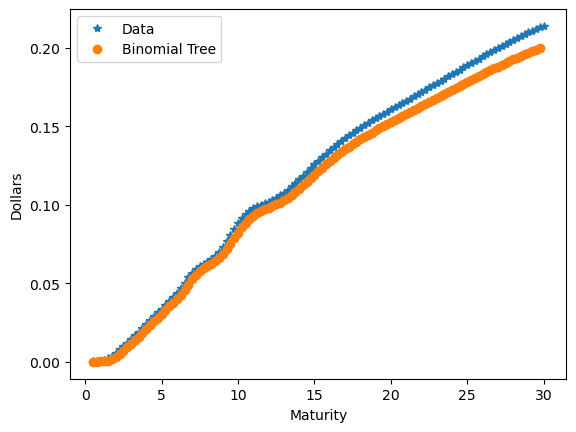

In [28]:
if dtstep==0.25:
    # Use the binomial tree to check if we price zeros and caps correctly.
    # only works if dtstep==0.25

    # compute caps and zeros on the tree
    CapTree = zeros((NN,NN,NN))
    for i in range(1,NN): # add one step to maturity to ensure the last bond has 30/dt to maturity (i=2 has 6 months to maturity)
        CapTree[0:i+1,i,i] = dt*exp(-ImTree[0:i+1,i]*dt)*maximum((exp(ImTree[0:i+1,i]*dt)-1)/dt-IntSwRate[i+1],0)
        # backward algorithm
        for j in range(i,0,-1):
            if j>1:
                CapTree[0:j,j-1,i] = exp(-ImTree[0:j,j-1]*dtstep)*(0.5*(CapTree[0:j,j,i]+CapTree[1:j+1,j,i]) + dtstep*maximum((exp(ImTree[0:j,j-1]*dtstep)-1)/dt-IntSwRate[i+1],0))
            else:
                CapTree[0:j,j-1,i] = exp(-ImTree[0:j,j-1]*dtstep)*(0.5*(CapTree[0:j,j,i]+CapTree[1:j+1,j,i]))
        a1 = CapTree[:,:, 0]
        a2 = CapTree[:,:, 1]
        if i==2:
            a3 = CapTree[:,:, 2]
    plt.figure(4)
    plt.plot(IntMat[1:],Caps,'*',IntMat[1:-1],CapTree[0,0,:],'o')
    plt.legend(('Data','Binomial Tree'),loc='best')
    plt.xlabel('Maturity')
    plt.ylabel('Dollars')

add shorter maturity to all of the vectors

parallell shift for duration computation

Intialize the Implied Tree

First note is the c.c. yield

egin the loop across all of the other values

%% Check if tree prices zeros and caps correctly

%% Check if tree prices caps correctly

%% Mortgages

mortgage characteristics

In [29]:
WAC = 4.492/100                  # weighted averge mortgage rate
WAM = int(round(311/12)/dtstep)  # number of periods, given step size in BDT model
PP0 = 100                        # reset current principal to 100
aa  = 1/(1+WAC*dtstep)

pass through coupon rate

In [30]:
rbar = 4/100

In [31]:
NN      = WAM # Redefine maturity using actual number of months left.
MCoupon = PP0*(1-aa)/(aa-aa**(NN+1)) # Monthly dollar coupon at time 0

%% Monte Carlo Simulations to price securities using additional frictions.

Number of simulations

In [32]:
NSim = 5000

Pre-Payment Parameters

In [55]:
c_1 = 0.62068   
c_2 = 0.001      
rm  = WAC         
sp  = 0.0025  

In [56]:
rK = 0.02      # Cap Rate
N  = 100      # Cap Notional

In [57]:
import numpy as np

np.random.seed(10)                 # equivalent to rand('seed',10); randn('seed',10)
PPsim2      = []                   # price of the pass-through
PPPOsim     = []                   # price of the PO strip
PPIOsim     = []                   # price of the IO strip
PPCAPsim    = []                   # price of the vanilla cap
PPACAPsim   = []                   # price of the Asian cap

for sim in range(NSim):

    # ------------- initialise state variables ---------------------
    Pri_t   = PP0                  # outstanding principal
    Ct      = MCoupon             # scheduled coupon (dollar amount)
    j       = 1                   # row index in the recombining tree (start at level 1)
    rrsim   = [ImTree[j, 1]]      # list that will hold the path of short-rates
                                   # first rate is the node (j=1, t=1*dtstep)

    CFPT2   = []                  # cash-flow path for the pass-through
    CFIO    = []                  # cash-flow path for the IO
    CFPO    = []                  # cash-flow path for the PO
    CFCAP   = []                  # cash-flow path for the cap
    CFACAP  = []                  # cash-flow path for the Asian cap

    # ----------------------------------------------------------------
    # traverse the tree from t = 2*dtstep to the second-to-last period
    # (MATLAB loop “for i = 2:NN-1”)
    # ----------------------------------------------------------------
    for i in range(2, NN):
        # ----- move up / down in the BDT tree -----------------------
        if np.random.rand() < 0.5:
            # up-move: stay on the same row index
            pass
        else:
            # down-move: go to the next row
            j += 1

        rsim = ImTree[j, i]       # short rate in this node
        rrsim.append(rsim)        # save it for discounting & Asian payoff later

        # ---------------- mortgage cash-flows -----------------------
        IntRatePay   = Pri_t * WAC * dtstep
        PriSchedule  = Ct - IntRatePay

        # single-month mortality (pre-payment) function
        SMM          = min(c_1 * max(rm - sp - rsim, c_2), 1.0)
        Prepay       = SMM * (Pri_t - PriSchedule)

        # pass-through pays interest at rbar, not at WAC
        IntRatePayPT = Pri_t * rbar * dtstep

        # total PT cash-flow this period
        CashFlowPT   = IntRatePayPT + PriSchedule + Prepay
        CFPT2.append(CashFlowPT)

        # IO & PO split
        CFIO.append(IntRatePayPT)
        CFPO.append(PriSchedule + Prepay)

        # update principal balance and coupon for next month
        Pri_t = max(Pri_t - (PriSchedule + Prepay), 0.0)
        Ct    = Ct * (1.0 - SMM)

        # ---------------- cap cash-flows ----------------------------
        # vanilla caplet payoff each month
        CashFlowCAP  = N * dtstep * max(rsim - rK, 0.0)
        CFCAP.append(CashFlowCAP)

        # Asian cap: payoff on the running average of realised short-rates
        CashFlowACAP = N * dtstep * max(np.mean(rrsim) - rK, 0.0)
        CFACAP.append(CashFlowACAP)

    # --------------- present-value the simulated leg ----------------
    times            = np.arange(1, len(CFPT2) + 1) * dtstep
    discount_factors = np.exp(-np.array(rrsim[1:]) * times)   # r(t−1) * t*dtstep

    PPsim2.append(np.sum(np.array(CFPT2)  * discount_factors))
    PPPOsim.append(np.sum(np.array(CFPO)  * discount_factors))
    PPIOsim.append(np.sum(np.array(CFIO)  * discount_factors))
    PPCAPsim.append(np.sum(np.array(CFCAP) * discount_factors))
    PPACAPsim.append(np.sum(np.array(CFACAP) * discount_factors))

# --------------------------------------------------------------------
# After the loop you will have NSim simulated prices in the five lists
# --------------------------------------------------------------------
PPsim2      = np.array(PPsim2)
PPPOsim     = np.array(PPPOsim)
PPIOsim     = np.array(PPIOsim)
PPCAPsim    = np.array(PPCAPsim)
PPACAPsim   = np.array(PPACAPsim)
print("Target price :", 106.5781)
print("Pass-Through mean price :", PPsim2.mean())
print("PO mean price          :", PPPOsim.mean())
print("IO mean price          :", PPIOsim.mean())
print("Cap mean price         :", PPCAPsim.mean())
print("Asian Cap mean price   :", PPACAPsim.mean())


Target price : 106.5781
Pass-Through mean price : 106.57810243386263
PO mean price          : 75.55200998128679
IO mean price          : 31.02609245257584
Cap mean price         : 15.66843133837506
Asian Cap mean price   : 7.497217378972171


In [54]:
# convert to NumPy for stats
PPsim2   = np.asarray(PPsim2)
PPIOsim  = np.asarray(PPIOsim)
PPPOsim  = np.asarray(PPPOsim)
PPCAPsim = np.asarray(PPCAPsim)
PPACAPsim= np.asarray(PPACAPsim)

# point estimates (per 100 face) and MC standard errors
PPPT2  = PPsim2.mean();  SEPT2  = PPsim2.std(ddof=1)/np.sqrt(NSim)
PPIO   = PPIOsim.mean(); SEIO   = PPIOsim.std(ddof=1)/np.sqrt(NSim)
PPPO   = PPPOsim.mean(); SEPO   = PPPOsim.std(ddof=1)/np.sqrt(NSim)
PPCAP  = PPCAPsim.mean();SECAP  = PPCAPsim.std(ddof=1)/np.sqrt(NSim)
PPACAP = PPACAPsim.mean();SEACAP= PPACAPsim.std(ddof=1)/np.sqrt(NSim)

print(' Pricing by Monte Carlo Simulations with "Irrational" Refinancing')
print(' ----------------------------------------------------------------')
print('Pass Through, IO Tranche, PO Tranche, CAP, Asian Cap')
print([PPPT2/PP0*100,  PPIO/PP0*100,  PPPO/PP0*100,  PPCAP,  PPACAP])
print('standard errors')
print([SEPT2/PP0*100, SEIO/PP0*100, SEPO/PP0*100, SECAP, SEACAP])

 Pricing by Monte Carlo Simulations with "Irrational" Refinancing
 ----------------------------------------------------------------
Pass Through, IO Tranche, PO Tranche, CAP, Asian Cap
[106.57830203971854, 31.02759625154, 75.55070578817858, 15.66843133837506, 7.497217378972171]
standard errors
[0.21868943533480564, 0.03472502868989407, 0.20806790891785887, 0.17735843294718556, 0.15406686959322535]


Set a seed for spot rate computations. By uncommenting the line below,<br>
the random draws are always the same (from here on) and so we can use<br>
different draws to compute spot rate duration etc

and('seed',10); randn('seed',10);

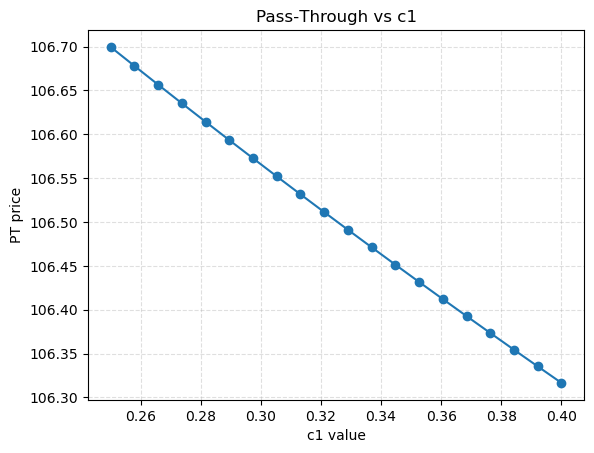

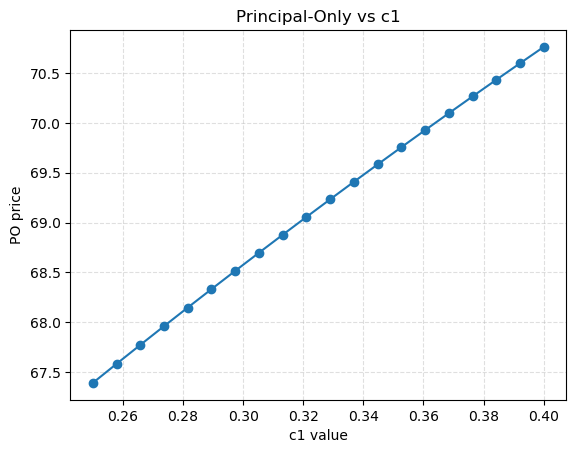

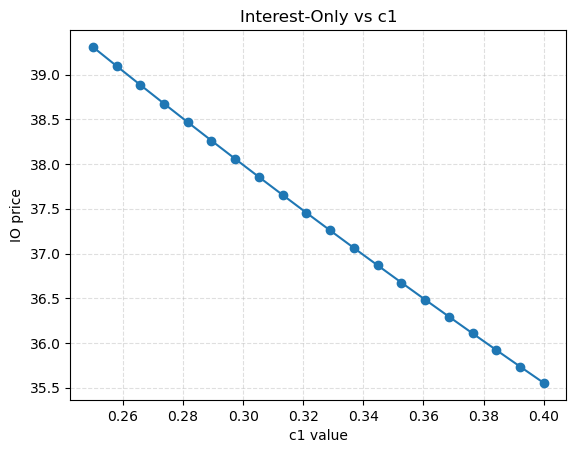

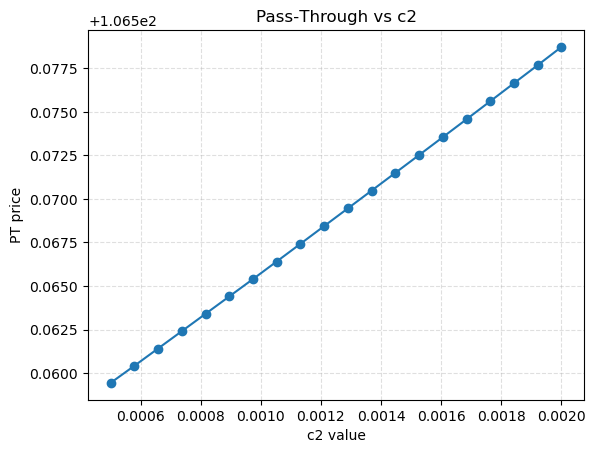

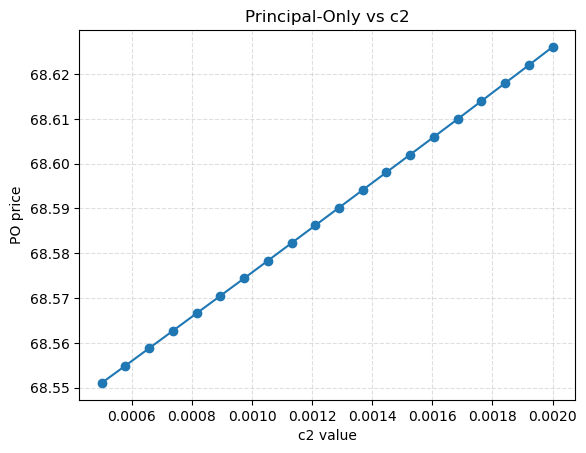

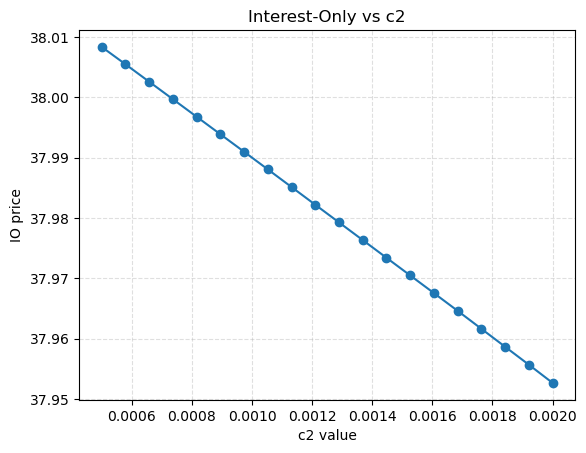

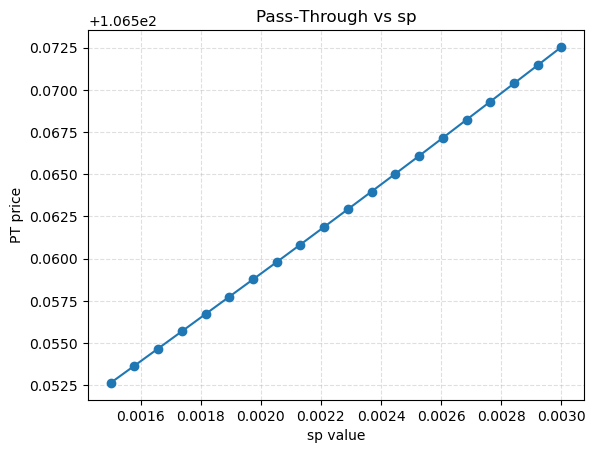

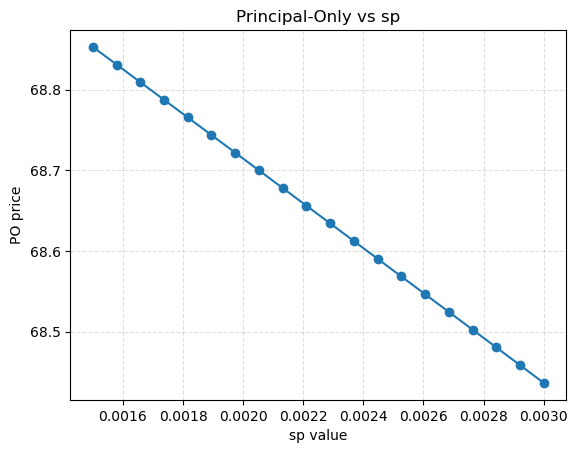

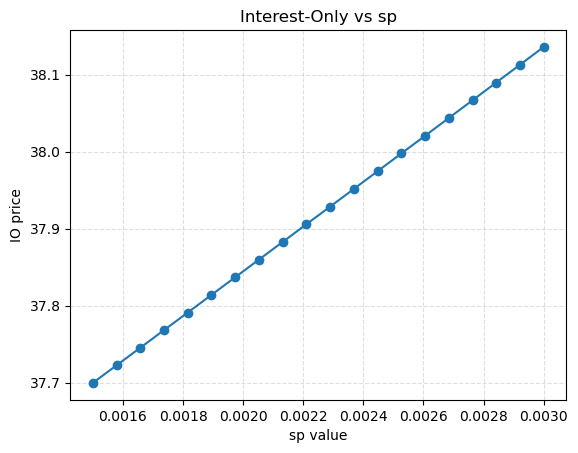

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# ---- pricing function from previous step (reuse if already in workspace) ----
def price_mbs_pool(
        NSim=2000,
        c1=0.30, c2=0.0010, sp=0.0025,  # pre-payment parameters
        rm=WAC,                         # borrower note rate (usually = WAC)
        rK=0.02, N=100,                 # cap strike & notional
        seed=10):
        
    rng = np.random.default_rng(seed)
    pt_paths = np.empty(NSim)
    po_paths = np.empty(NSim)
    io_paths = np.empty(NSim)

    for sim in range(NSim):
        Pri_t = PP0
        Ct    = MCoupon
        j     = 1
        rrsim = [ImTree[j, 1]]

        CFPT, CFPO, CFIO = [], [], []

        for i in range(2, NN):
            if rng.random() >= 0.5:
                j += 1
            rsim = ImTree[j, i]
            rrsim.append(rsim)

            int_sched = Pri_t * WAC * dtstep
            pri_sched = Ct - int_sched

            SMM = min(c1 * max(rm - sp - rsim, c2), 1.0)
            prep = SMM * (Pri_t - pri_sched)

            int_PT = Pri_t * rbar * dtstep

            CFPT.append(int_PT + pri_sched + prep)
            CFIO.append(int_PT)
            CFPO.append(pri_sched + prep)

            Pri_t = max(Pri_t - (pri_sched + prep), 0.0)
            Ct   *= (1.0 - SMM)

        times = np.arange(1, len(CFPT) + 1) * dtstep
        discs = np.exp(-np.array(rrsim[1:]) * times)
        pt_paths[sim] = (discs * CFPT).sum()
        po_paths[sim] = (discs * CFPO).sum()
        io_paths[sim] = (discs * CFIO).sum()

    return pt_paths.mean(), po_paths.mean(), io_paths.mean()

# ---------------- parameter grids ----------------
arr_len = 20
c1_vals = np.linspace(0.25, 0.40, arr_len)           # slope coefficient
c2_vals = np.linspace(0.0005, 0.0020, arr_len)       # turnover floor
sp_vals = np.linspace(0.0015, 0.0030, arr_len)       # refi hurdle

# storage for results
pt_c1, po_c1, io_c1 = [], [], []
pt_c2, po_c2, io_c2 = [], [], []
pt_sp, po_sp, io_sp = [], [], []

# ----- vary c1 -----
for c1 in c1_vals:
    pt, po, io = price_mbs_pool(c1=c1, c2=0.0010, sp=0.0025)
    pt_c1.append(pt); po_c1.append(po); io_c1.append(io)

# ----- vary c2 -----
for c2 in c2_vals:
    pt, po, io = price_mbs_pool(c1=0.30, c2=c2, sp=0.0025)
    pt_c2.append(pt); po_c2.append(po); io_c2.append(io)

# ----- vary sp -----
for sp in sp_vals:
    pt, po, io = price_mbs_pool(c1=0.30, c2=0.0010, sp=sp)
    pt_sp.append(pt); po_sp.append(po); io_sp.append(io)
# pt_c1

# ---------------- plotting helper ----------------

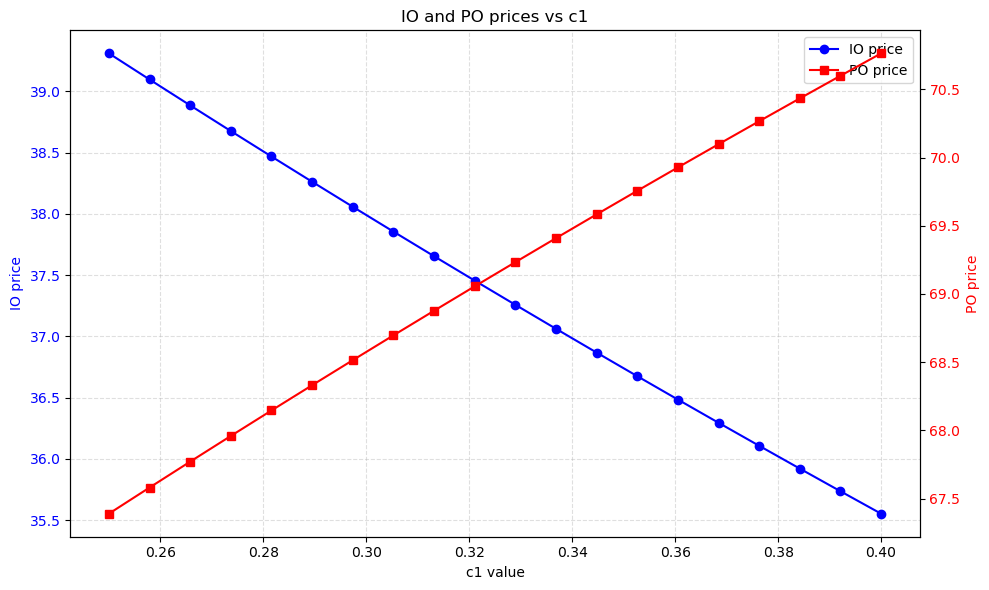

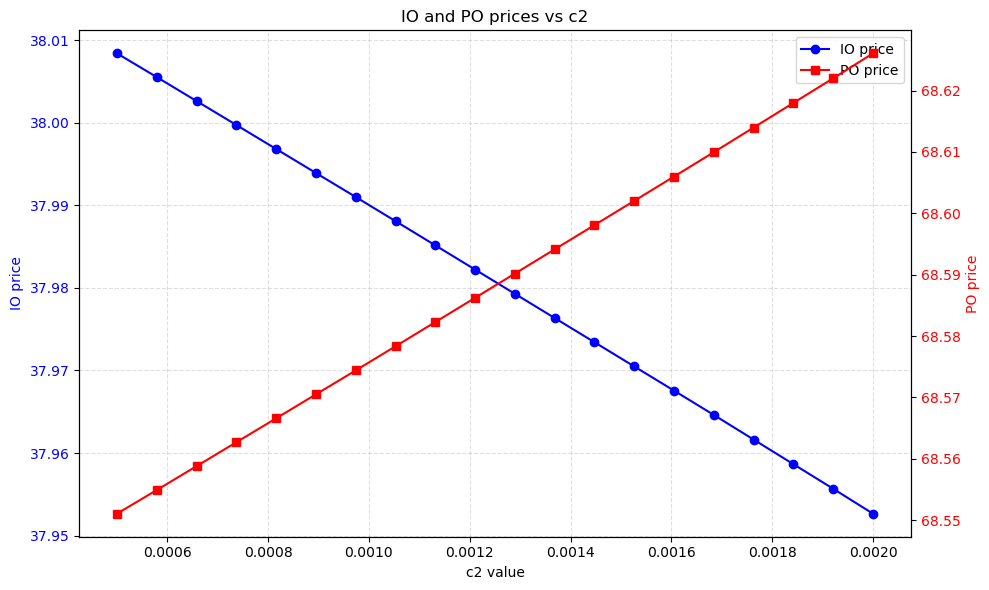

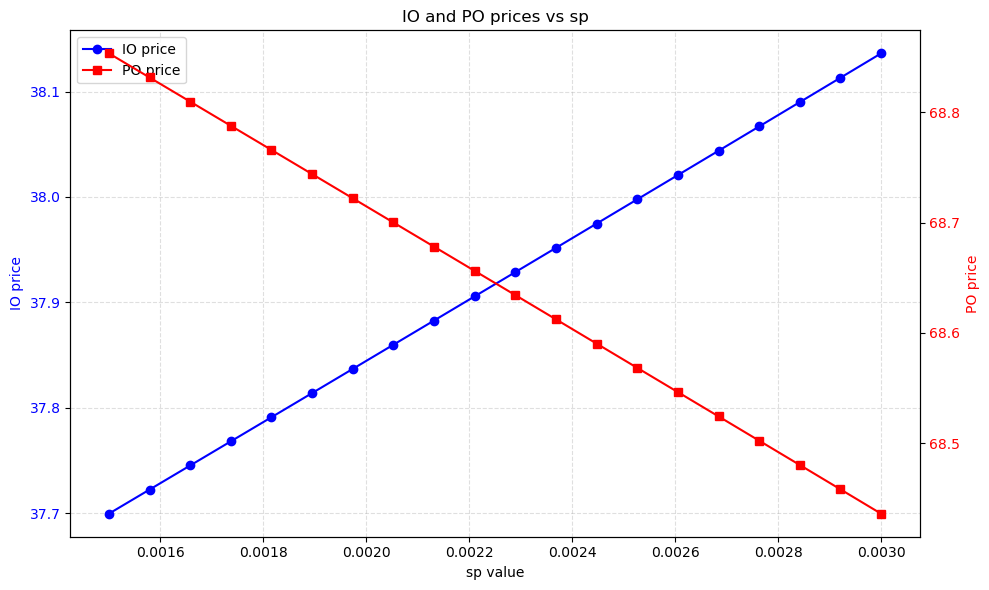

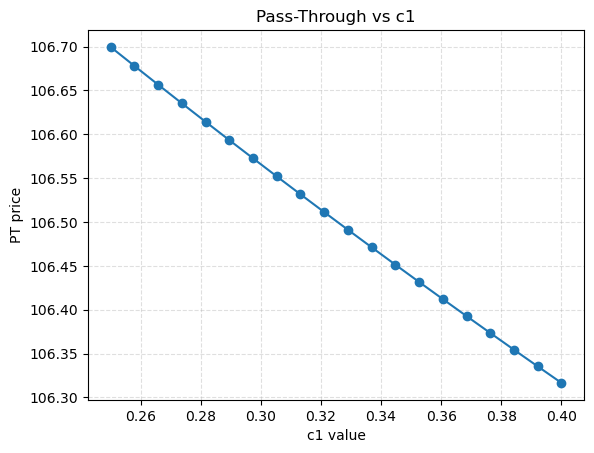

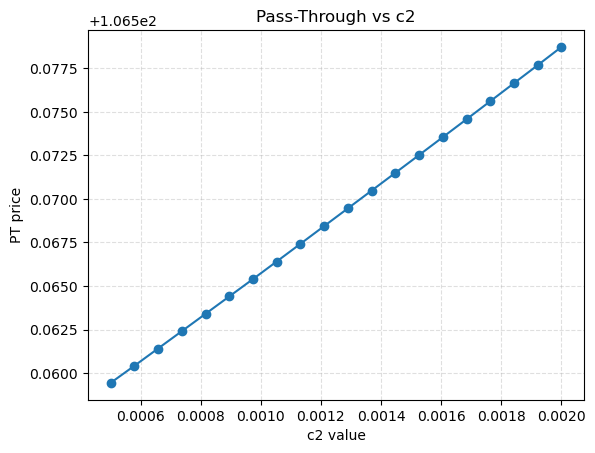

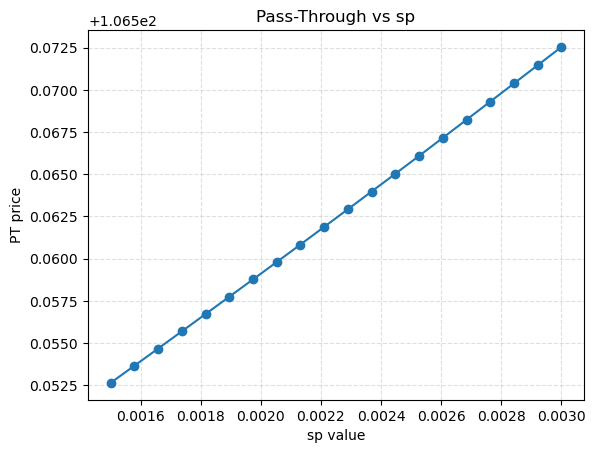

In [58]:
def dual_line_chart(x, y1, y2, xlabel, y1label, y2label, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # First plot with left y-axis
    ax.plot(x, y1, marker='o', color='blue', label=y1label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(y1label, color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Second plot with right y-axis
    ax2 = ax.twinx()
    ax2.plot(x, y2, marker='s', color='red', label=y2label)
    ax2.set_ylabel(y2label, color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Add grid and title
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.set_title(title)
    
    # Add legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.tight_layout()
    plt.show()

# ------------- Three figures with IO and PO plots ----------------

# c1 variations
dual_line_chart(c1_vals, io_c1, po_c1, "c1 value", "IO price", "PO price", "IO and PO prices vs c1")

# c2 variations
dual_line_chart(c2_vals, io_c2, po_c2, "c2 value", "IO price", "PO price", "IO and PO prices vs c2")

# sp variations
dual_line_chart(sp_vals, io_sp, po_sp, "sp value", "IO price", "PO price", "IO and PO prices vs sp")

# If you still want to show the Pass-Through (PT) plots separately:
line_chart(c1_vals, pt_c1, "c1 value", "PT price", "Pass-Through vs c1")
line_chart(c2_vals, pt_c2, "c2 value", "PT price", "Pass-Through vs c2")
line_chart(sp_vals, pt_sp, "sp value", "PT price", "Pass-Through vs sp")